# Organ comparison DGE list
# 20 Oct 2021 Chenqu

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
from itertools import compress
import random
import joblib as jl
import matplotlib.patches as mpatches

sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
#plt.rcParams['font.sans-serif']=['Arial']
#rc('font', **{'family':'sans-serif', 'sans-serif':['Arial']})
#plt.rcParams['pdf.fonttype'] = 'truetype'

In [2]:
sb.set_palette('tab10')

In [4]:
# # import utils
# import sys
# sys.path.append('/home/jovyan/chenqu_utils')
# from array_operations import *
# sys.path.append('/home/jovyan/thymusatlas/')
# import scjp
# from scjp import model

In [5]:
organ_order = ['YS','LI','BM','TH','SP','MLN','SK','GU','KI']

In [5]:
# set working directory
%cd /home/jovyan/panfetal/

/home/jovyan/panfetal


In [6]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/Pan_fetal/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

dependencies for enrichr and plotting

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

In [8]:
gp.__version__

'0.10.5'

In [9]:
names = gp.get_library_name() # default: Human

# Load data

In [10]:
adata = sc.read('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.HSC_IMMUNE.embedding.annotated.h5ad')

Only considering the two last: ['.annotated', '.h5ad'].
Only considering the two last: ['.annotated', '.h5ad'].


In [11]:
adata.raw = adata.copy()

In [12]:
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) 
# final annotations and removed maternal contaminant cells, all the cells

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
for col in obs:
    adata.obs[col]=obs[col]

In [14]:
adata.obs['donor_organ']=np.char.array(adata.obs['donor'],unicode=True)+'_'+np.char.array(adata.obs['organ'],unicode=True)

# TH vs other organ T cells

## GSEA plot for significant DGEs

In [91]:
DGE = pd.read_csv('csv/DE_results_THtcells_THvsOther_compiled_neglfc.csv') 

In [92]:
gene_list = list(DGE['Var1'])

In [93]:
gene_sets=['MSigDB_Hallmark_2020']

In [94]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [95]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,7/199,0.000082,0.001223,0,0,7.405928,69.707145,SOCS2;GABARAPL1;AHNAK;CISH;PTGER2;IL18R1;SERPINB6
1,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/200,0.000084,0.001223,0,0,7.367181,69.111138,NR4A2;SOCS3;PLEK;FOSB;SIK1;JUNB;KLF2
2,MSigDB_Hallmark_2020,Apoptosis,5/161,0.001539,0.014877,0,0,6.390831,41.391066,ANXA1;LMNA;FAS;TSPO;CDC25B
3,MSigDB_Hallmark_2020,Interferon Gamma Response,5/200,0.003932,0.019006,0,0,5.102564,28.260755,SOCS3;FAS;UPP1;SAMHD1;HLA-DRB1
4,MSigDB_Hallmark_2020,Complement,5/200,0.003932,0.019006,0,0,5.102564,28.260755,FCER1G;ITGAM;PLEK;S100A9;CD55


In [96]:
# to save your figure, make sure that ``ofname`` is not None
ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff=1, top_terms=10,figsize=(6,6),ofname=fig_path+'THvsothersTcells_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [97]:
# add KLF2 in neglfc gene list

In [105]:
genes = enr.results.iloc[1,9].split(';') 
cts = ['CD4+T','CD8+T','TREG','TH17','NK_T']

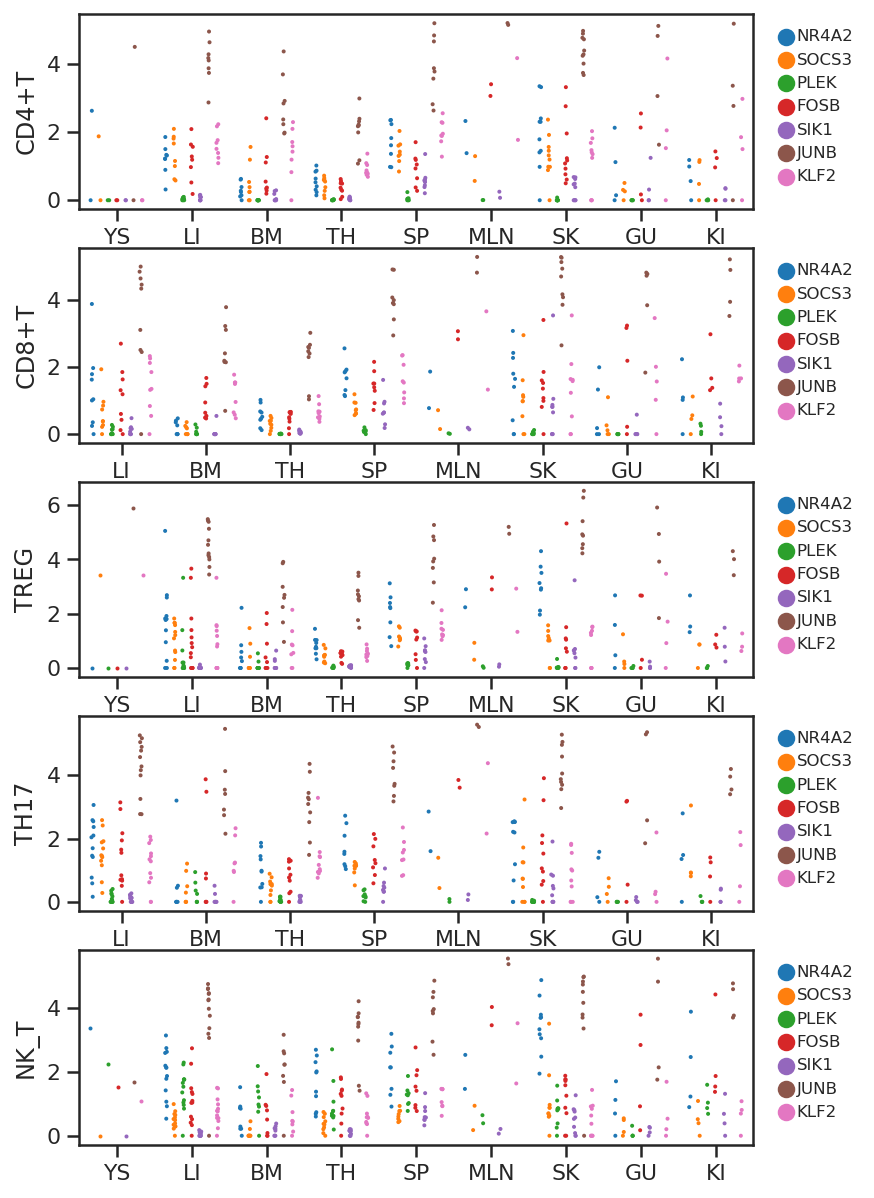

In [106]:
fig, ax = plt.subplots(5,1,figsize=(6,10))
for j in range(5):
    ct = cts[j]
    ct_data = adata[adata.obs['anno_lvl_2_final_clean']==ct]
    
    donor_organ_list = set(ct_data.obs['donor_organ'])
    df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])
    df['donor_organ']=list(donor_organ_list)*len(genes)
    df['genes']=np.repeat(np.array(genes),len(donor_organ_list))
    
    for i in df.index: 
        donor_organ = df['donor_organ'][i]
        data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
        gene = df['genes'][i]
        df.iloc[i,3]=np.mean(data_select[:,gene].X)
    
    df['donor']=[name.split('_')[0] for name in df['donor_organ']]
    df['organ']=[name.split('_')[1] for name in df['donor_organ']]
    
    df['organ']=df['organ'].astype('category')
    df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])
    
    #plt.rcParams["figure.figsize"] = [8,8]
    sb.set_theme(style='ticks')
    s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2,ax=ax[j])
    s.set(ylabel=ct)
    s.set(xlabel='')
    #ax[j].set_ylim([0, 1])
    ax[j].legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')

plt.savefig(fig_path+'DE_results_THtcells_THvsOther_compiled_neglfc.pdf',bbox_inches='tight')

dotplot

In [107]:
df4 = pd.DataFrame(index = range(11), columns=['organ','ct']+genes)

In [108]:
df4['organ']=['TH']*6+['others']*5
df4['ct']=['ABT(ENTRY)']+['CD4+T','CD8+T','TREG','TH17','NK_T']*2

In [109]:
for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='TH':
        a = np.array(adata.obs['organ'].isin(['TH']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['TH'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)

In [110]:
df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

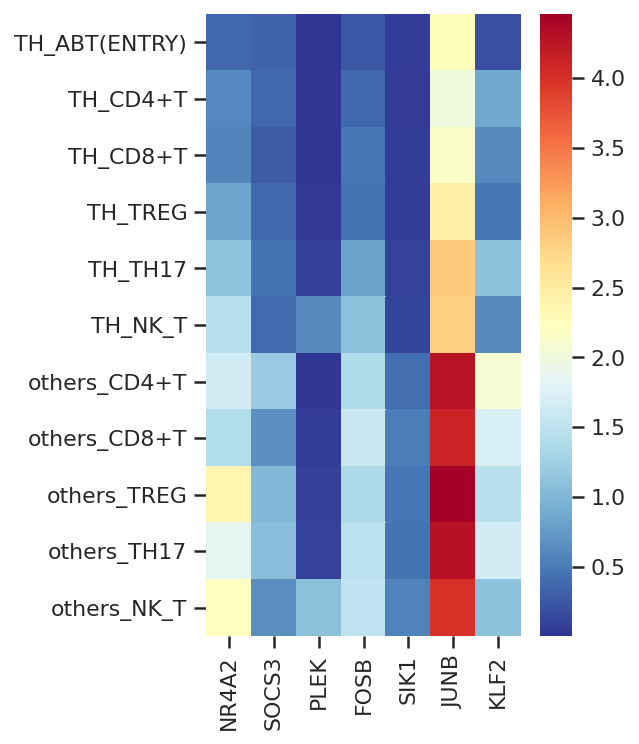

In [111]:
fig, ax = plt.subplots(figsize=(df5.shape[1]/2,df5.shape[0]/2))
sb.heatmap(df5,cmap='RdYlBu_r')
plt.savefig(fig_path+'THvsothersTcells_neglfc_heatmap.pdf',bbox_inches='tight');

# TH vs other organ B1

## GSEA plot for significant DGEs

In [132]:
DGE = pd.read_csv('csv/DE_results_THB1_THvsOther_compiled_neglfc.csv') # no significant enrichement in neglfc

In [133]:
gene_list = list(DGE['Var1'])

In [134]:
gene_sets=['MSigDB_Hallmark_2020']

In [135]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [136]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,6/199,0.000334,0.010701,0,0,7.044488,56.378213,CCND2;AHCY;CA2;MAPKAPK2;ODC1;ITGAE
1,MSigDB_Hallmark_2020,Fatty Acid Metabolism,5/158,0.000858,0.013727,0,0,7.335859,51.798316,ALDH3A2;CA2;ODC1;CD1D;CRYZ
2,MSigDB_Hallmark_2020,mTORC1 Signaling,4/200,0.014197,0.113575,0,0,4.519835,19.230709,PSMA3;SDF2L1;TOMM40;ATP5MC1
3,MSigDB_Hallmark_2020,Xenobiotic Metabolism,4/200,0.014197,0.113575,0,0,4.519835,19.230709,AHCY;CA2;ABHD6;MAN1A1
4,MSigDB_Hallmark_2020,Apoptosis,3/161,0.039269,0.236580,0,0,4.166456,13.488100,CCND2;PDCD4;CD38


In [137]:
# to save your figure, make sure that ``ofname`` is not None
ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff=1, top_terms=10,figsize=(6,6),ofname=fig_path+'THvsothersB1_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [138]:
genes = enr.results.iloc[0,9].split(';') 

In [139]:
ct_data = adata[adata.obs['anno_lvl_2_final_clean']=='B1']

In [140]:
donor_organ_list = set(ct_data.obs['donor_organ'])
df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])

In [141]:
df['donor_organ']=list(donor_organ_list)*len(genes)
df['genes']=np.repeat(np.array(genes),len(donor_organ_list))

In [142]:
for i in df.index: 
    donor_organ = df['donor_organ'][i]
    data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
    gene = df['genes'][i]
    df.iloc[i,3]=np.mean(data_select[:,gene].X)

In [143]:
df['donor']=[name.split('_')[0] for name in df['donor_organ']]
df['organ']=[name.split('_')[1] for name in df['donor_organ']]

In [144]:
df['organ']=df['organ'].astype('category')
df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])

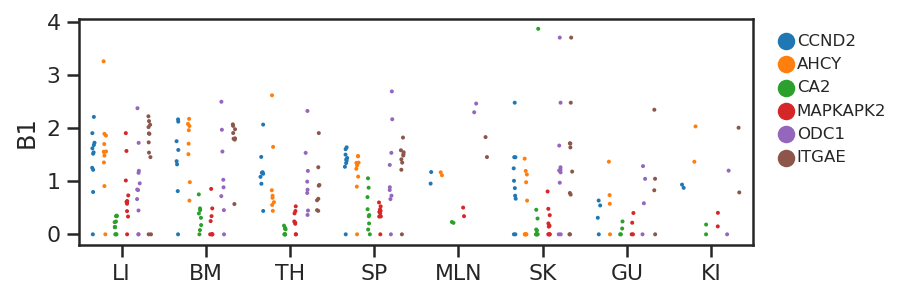

In [145]:
#plt.rcParams["figure.figsize"] = [8,8]
sb.set_theme(style='ticks')
fig, ax = plt.subplots(figsize=(6,2))
s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2)
s.set(ylabel='B1')
s.set(xlabel='')
ax.legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')
#plt.savefig('figures/MONOCYTE_III_CCR2.pdf',bbox_inches='tight')

dotplot

In [146]:
df4 = pd.DataFrame(index = range(2), columns=['organ','ct']+genes)

In [147]:
df4['organ']=['TH','others']
df4['ct']=['B1']*2

In [148]:
for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='TH':
        a = np.array(adata.obs['organ'].isin(['TH']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['TH'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)

In [149]:
df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

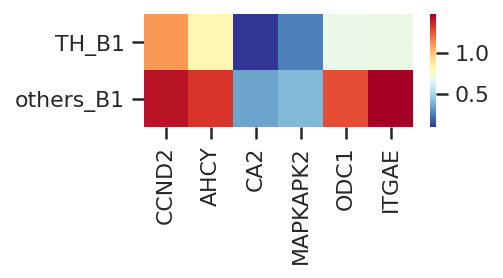

In [150]:
fig, ax = plt.subplots(figsize=(df5.shape[1]/2,df5.shape[0]/2))
sb.heatmap(df5,cmap='RdYlBu_r')
plt.savefig(fig_path+'THvsothersB1_neglfc_heatmap.pdf',bbox_inches='tight');

# BM vs other organ CCR2 monocytes

## GSEA plot for significant DGEs

In [56]:
DGE = pd.read_csv('csv/DE_results_CCR2MONO_BMvsOther_compiled_neglfc.csv')

In [57]:
gene_list = list(DGE['Var1'])

In [58]:
gene_sets=['MSigDB_Hallmark_2020']

In [59]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=gene_sets,
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='csv/enrichr/',
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [60]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/200,0.000047,0.001703,0,0,8.124352,80.909869,IL1B;PLAUR;TRIP10;G0S2;HES1;SOD2;PNRC1
1,MSigDB_Hallmark_2020,KRAS Signaling Up,6/200,0.000385,0.006934,0,0,6.849647,53.849903,MAFB;TSPAN13;IL1B;C3AR1;PLAUR;G0S2
2,MSigDB_Hallmark_2020,Pperoxisome,4/104,0.001528,0.018340,0,0,8.705495,56.442952,ACSL1;BCL10;SOD2;DHRS3
3,MSigDB_Hallmark_2020,Inflammatory Response,5/200,0.002662,0.023961,0,0,5.615385,33.291011,IL1R1;IL1B;OSM;C3AR1;PLAUR
4,MSigDB_Hallmark_2020,Cholesterol Homeostasis,3/74,0.005275,0.037977,0,0,9.109308,47.776950,PLAUR;CPEB2;PNRC1


In [61]:
# to save your figure, make sure that ``ofname`` is not None
ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff = 1,top_terms=5,figsize=(6,6),ofname=fig_path+'BMvsothersCCR2MONO_neglfc_enrichr.pdf')

## Plot significant DGEs in organ comparison 

In [62]:
genes = enr.results.iloc[0,9].split(';') 
print(genes)

['IL1B', 'PLAUR', 'TRIP10', 'G0S2', 'HES1', 'SOD2', 'PNRC1']


In [63]:
ct_data = adata[adata.obs['anno_lvl_2_final_clean']=='MONOCYTE_III_CCR2']

In [64]:
genes = enr.results.iloc[0,9].split(';')

In [65]:
donor_organ_list = set(ct_data.obs['donor_organ'])
df = pd.DataFrame(index = range(len(donor_organ_list) * len(genes)), columns = ['donor_organ','donor','organ','expression','gene'])

In [66]:
df['donor_organ']=list(donor_organ_list)*len(genes)
df['genes']=np.repeat(np.array(genes),len(donor_organ_list))

In [67]:
for i in df.index: 
    donor_organ = df['donor_organ'][i]
    data_select = ct_data[ct_data.obs['donor_organ']==donor_organ]
    gene = df['genes'][i]
    df.iloc[i,3]=np.mean(data_select[:,gene].X)

In [68]:
df['donor']=[name.split('_')[0] for name in df['donor_organ']]
df['organ']=[name.split('_')[1] for name in df['donor_organ']]

In [69]:
df['organ']=df['organ'].astype('category')
df['organ']=df['organ'].cat.reorder_categories([organ for organ in organ_order if organ in set(df['organ'])])

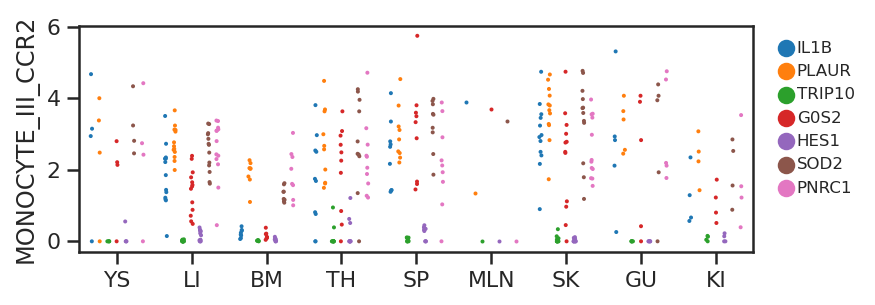

In [70]:
#plt.rcParams["figure.figsize"] = [8,8]
sb.set_theme(style='ticks')
fig, ax = plt.subplots(figsize=(6,2))
s = sb.stripplot(x="organ", y="expression",hue='genes',data=df, palette="tab10",dodge=True,size=2)
s.set(ylabel='MONOCYTE_III_CCR2')
s.set(xlabel='')
ax.legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='x-small')
plt.savefig(fig_path+'CCR2MONO_neglfc_stripplot.pdf',bbox_inches='tight')

combine poslfc and neglfc for dotplot and use adata_scale 

In [71]:
df4 = pd.DataFrame(index = range(2), columns=['organ','ct']+genes)

In [72]:
df4['organ']=['BM','others']
df4['ct']=['MONOCYTE_III_CCR2']*2

In [73]:
for i in df4.index:
    ct = df4['ct'][i]
    
    if df4['organ'][i]=='BM':
        a = np.array(adata.obs['organ'].isin(['BM']))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)
    else:
        a = np.array(~(adata.obs['organ'].isin(['BM'])))
        b = np.array(adata.obs['anno_lvl_2_final_clean']==ct)
        data_select=adata[list(a&b)]
        
        for gene in genes:
            df4[gene][i] = np.mean(data_select[:,gene].X)

In [74]:
df5 = df4.iloc[:,2:].astype('float')
df5.index=df4['organ']+'_'+df4['ct']

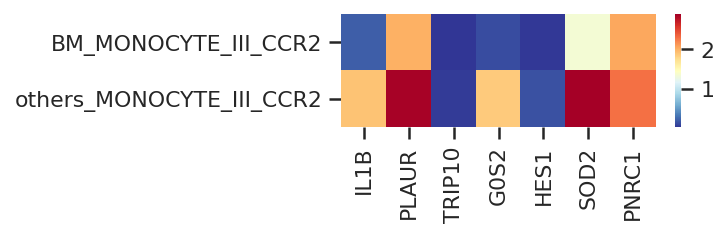

In [75]:
fig, ax = plt.subplots(figsize=(df5.shape[1]/2,df5.shape[0]/2))
sb.heatmap(df5,cmap='RdYlBu_r')
plt.savefig(fig_path+'CCR2MONO_neglfc_heatmap.pdf',bbox_inches='tight');